Импорт библиотек которые до этого не описывались:

    datetime: библиотека для работы с датами и временем.
    
    re: библиотека для работы с регулярными выражениями, полезна для поиска, сопоставления и обработки строк по определенным шаблонам.
    
    sklearn.cluster.KMeans: модуль библиотеки scikit-learn для выполнения алгоритма кластеризации KMeans, который группирует данные на основе близости к     центроидам.
    
    sklearn.preprocessing.StandardScaler: нормализует данные, приводя их к единому масштабу (среднее значение 0, стандартное отклонение 1), что важно        для моделей машинного обучения.
    
    numpy: библиотека для численных вычислений и работы с многомерными массивами, поддерживающая линейную алгебру и математику.
    
    plotly: библиотека для интерактивной визуализации данных с возможностью создания динамических графиков для анализа данных.
    
    warnings: модуль для контроля и обработки предупреждений, позволяя подавлять или выводить сообщения о предупреждениях.
    
    os: Стандартная библиотека для взаимодействия с операционной системой, например, для управления переменными окружения, файловой системы и процессов.

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import plotly as py
import warnings
import os
warnings.filterwarnings("ignore")
py.offline.init_notebook_mode(connected = True)

data = pd.read_csv('US_Stock_Data.csv')

numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
object_cols = list(data.select_dtypes(include=['object']).columns)

Добавление в датасет нового атрибута который показывает сколько дней прошло с даты указанной в датасете и показа первых 15 строк с датой и сколько дней прошло с этой даты

In [16]:
def convert_to_numeric(value):
    try:
        return float(value.replace(',', ''))
    except (ValueError, AttributeError):
        return value

def clean_date_format(date_str):
    if re.match(r'\d{2}-\d{2}-\d{4}', date_str):
        date_obj = datetime.strptime(date_str, '%d-%m-%Y')
        return date_obj.strftime('%d/%m/%Y')
    
    elif re.match(r'\d{1,2}/\d{1,2}/\d{4}', date_str):
        return date_str
    
    else:
        return None

for col in object_cols:
    data[col] = data[col].apply(convert_to_numeric)

# Применение функции ко всем значениям в столбце Date
data['Date'] = data['Date'].apply(lambda x: clean_date_format(str(x)))

# Удаляем строки с некорректными датами (где дата None)
data = data.dropna(subset=['Date'])

# Преобразование столбца Date в формат datetime
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y', errors='coerce')

current_date = datetime.now()

data['Days_Ago'] = (current_date - data['Date']).dt.days

print(data[['Date', 'Days_Ago']].head(15))

for _ in range(15):
    print("-",end='')
print("-")
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
data.info()

         Date  Days_Ago
0  2024-02-02       256
1  2024-02-01       257
2  2024-01-31       258
3  2024-01-30       259
4  2024-01-29       260
5  2024-01-26       263
6  2024-01-25       264
7  2024-01-24       265
8  2024-01-23       266
9  2024-01-22       267
10 2024-01-19       270
11 2024-01-18       271
12 2024-01-17       272
13 2024-01-16       273
14 2024-01-12       277
----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1013 entries, 0 to 1012
Data columns (total 40 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Unnamed: 0         1013 non-null   int64         
 1   Date               1013 non-null   datetime64[ns]
 2   Natural_Gas_Price  1013 non-null   float64       
 3   Natural_Gas_Vol.   1009 non-null   float64       
 4   Crude_oil_Price    1013 non-null   float64       
 5   Crude_oil_Vol.     990 non-null    float64       
 6   Copper_Price       1013 non-null   float64     

Очистка датасета от всего лишнего, а именно удаление дубликатов, очистка от выбросов, обращу внимание на то, что данная очистка происходит не однократно, а 5 раз, так как IQR может быть недостаточно строгим и может их периодически пропускать, поэтому происходит несколько итераций для более качественной фильтрации. Далее по заданию нужно найти кривые данные, за такие данные я взял, что, например, цена акций компании не может быть отрицательной, далее я заново вывожу участок кода из прошлой лабораторной, чтобы проверить на то, что пропущенных значений и выбросов в датасете не имеется.

In [22]:
data = data.drop_duplicates()

for _ in range(6):
    for col in numeric_cols:
        data[col] = data[col].fillna(data[col].mean())
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

price_columns = [col for col in data.columns if 'Price' in col]

for col in price_columns:
    data = data[data[col] >= 0]

# проверка на отсутствие пропусков и выбросов
mean_std = data[numeric_cols].agg(['mean', 'std'])
for col in numeric_cols:
    print(f"название атрибута: {col}")
    mean_value = mean_std.loc['mean', col]
    std_value = mean_std.loc['std', col]
    print(f"Среднее значение: {mean_value}")
    print(f"Среднеквадратичное отклонение: {std_value}")

    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    print(f'Количество выбросов: {len(outliers)}')

    missing_count = data[col].isnull().sum()
    print(f'Количество пропущенных значений: {missing_count}\n')

название атрибута: Unnamed: 0
Среднее значение: 82.33333333333333
Среднеквадратичное отклонение: 32.624121954978854
Количество выбросов: 0
Количество пропущенных значений: 0

название атрибута: Natural_Gas_Price
Среднее значение: 3.279666666666667
Среднеквадратичное отклонение: 0.443238461026718
Количество выбросов: 0
Количество пропущенных значений: 0

название атрибута: Natural_Gas_Vol.
Среднее значение: 184516.66666666666
Среднеквадратичное отклонение: 47034.33462199007
Количество выбросов: 0
Количество пропущенных значений: 0

название атрибута: Crude_oil_Price
Среднее значение: 81.55
Среднеквадратичное отклонение: 1.4495861478366856
Количество выбросов: 0
Количество пропущенных значений: 0

название атрибута: Crude_oil_Vol.
Среднее значение: 332950.0
Среднеквадратичное отклонение: 12298.438925327067
Количество выбросов: 0
Количество пропущенных значений: 0

название атрибута: Copper_Price
Среднее значение: 3.672333333333333
Среднеквадратичное отклонение: 0.04041451884327371
Количе

Построение графиков зависимости объёма продаж от цены компании или ресурса. Из данных графиков сложно выявить какую-то одну общую тенденцию, и из каждого графика можно сделать свои выводы, например, из графика Apple видно, что чем акции дешевле, тем больше их берут, а чем дороже, тем объём покупок этих акций меньше, а вот из графика Nvidia видно как раз обратное, что дешёвые акции брали не очень охотно, а как они резко выросли в цене, то их стали более охотно покупать из-за естественной перспективы ещё больше подорожать после всех историй с нейронными сетями.

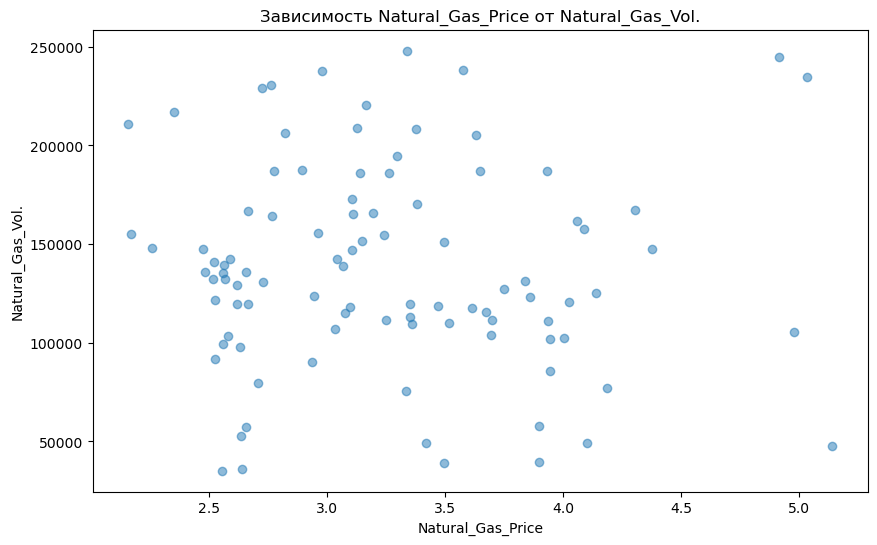

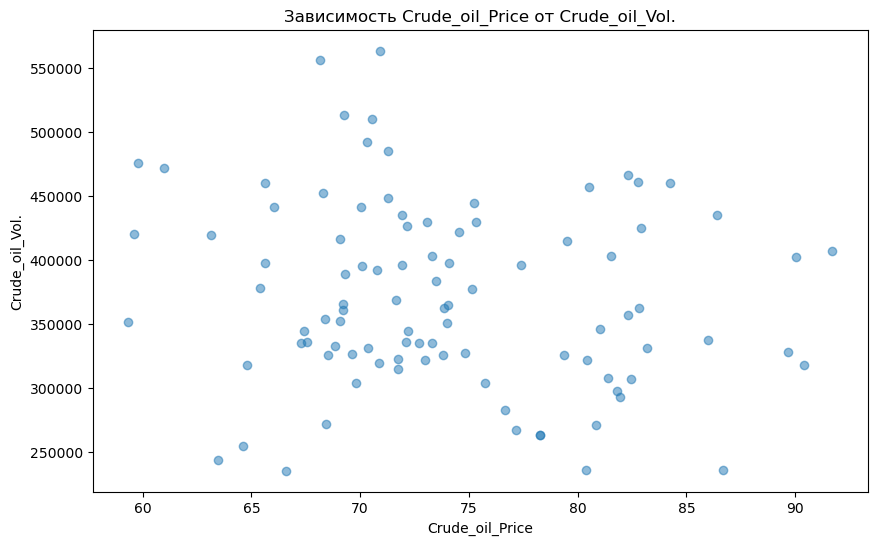

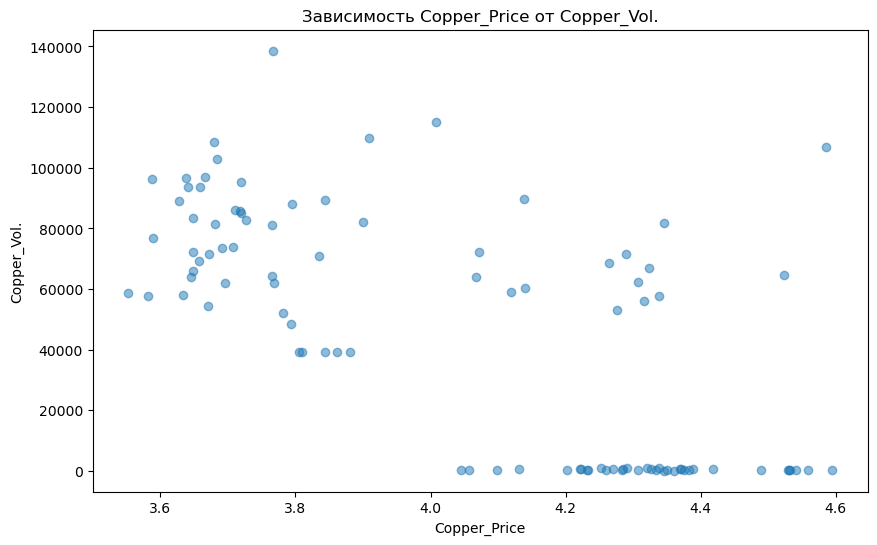

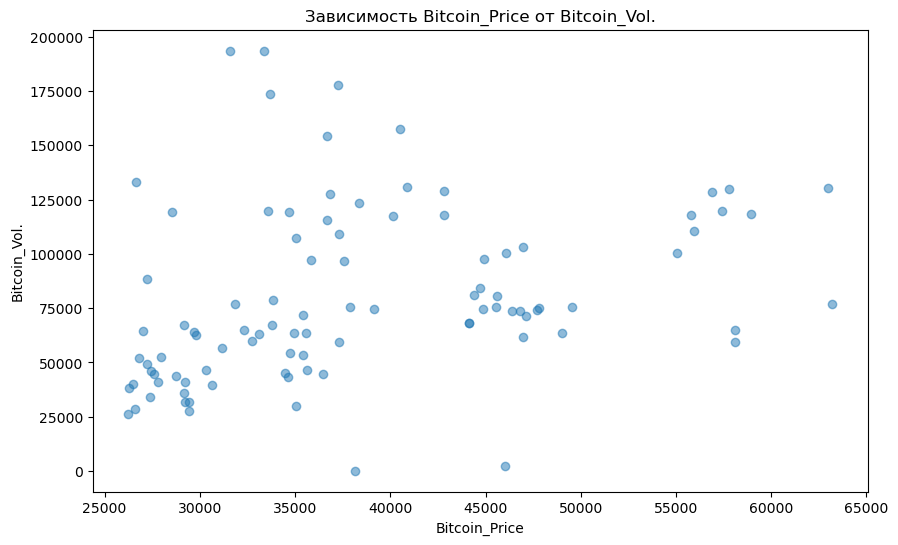

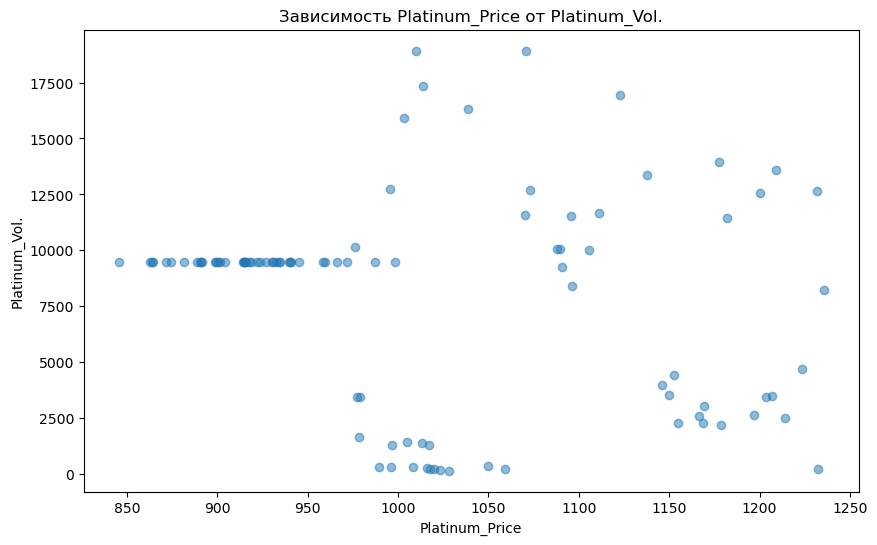

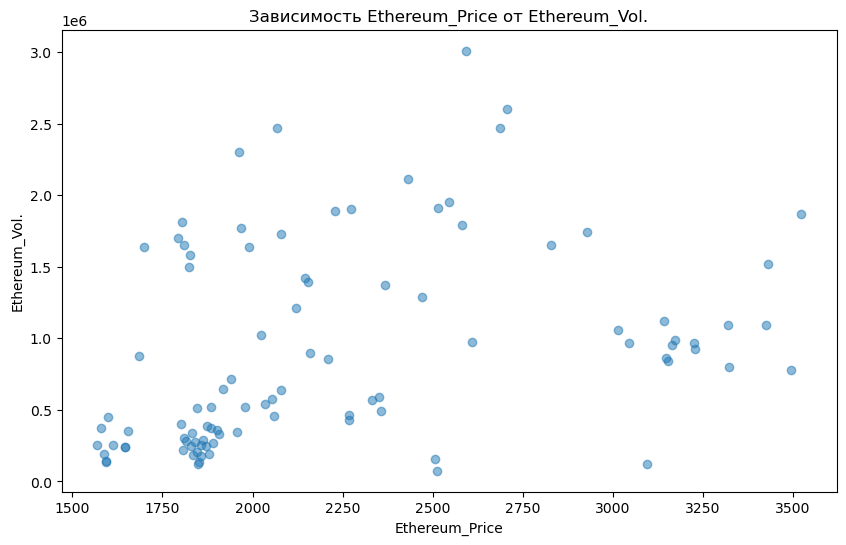

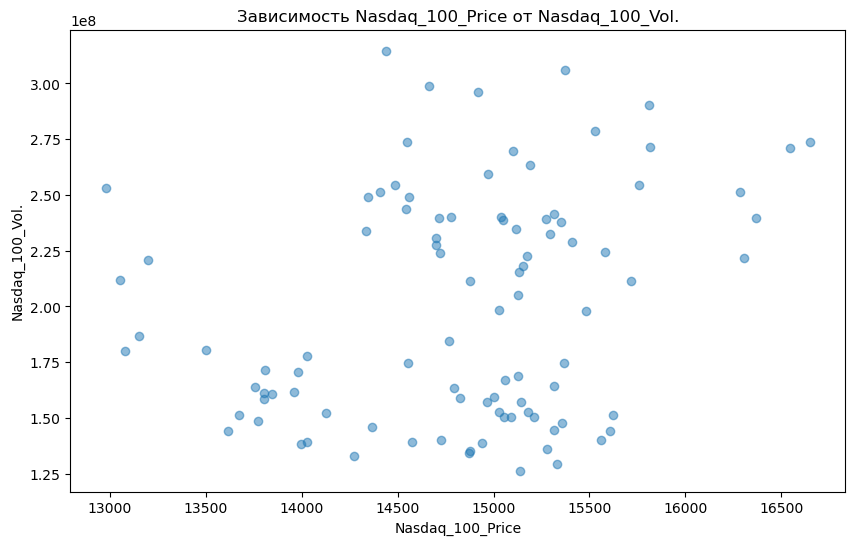

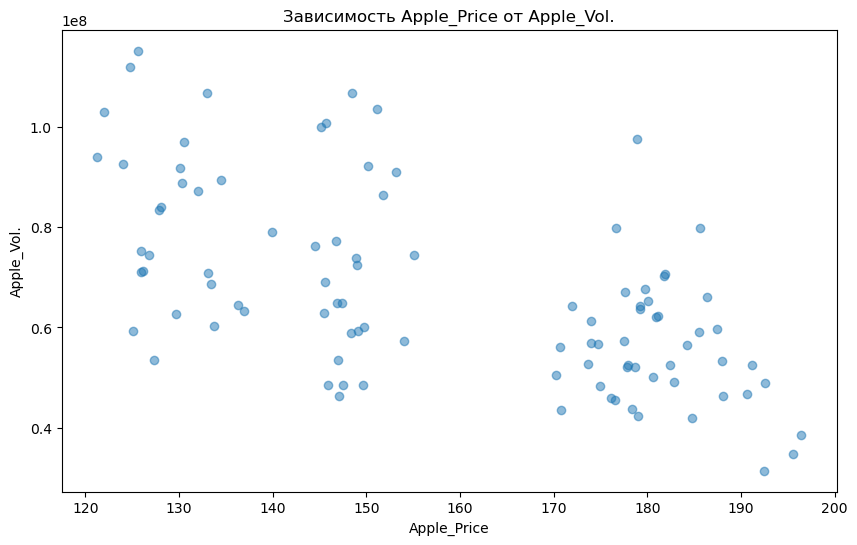

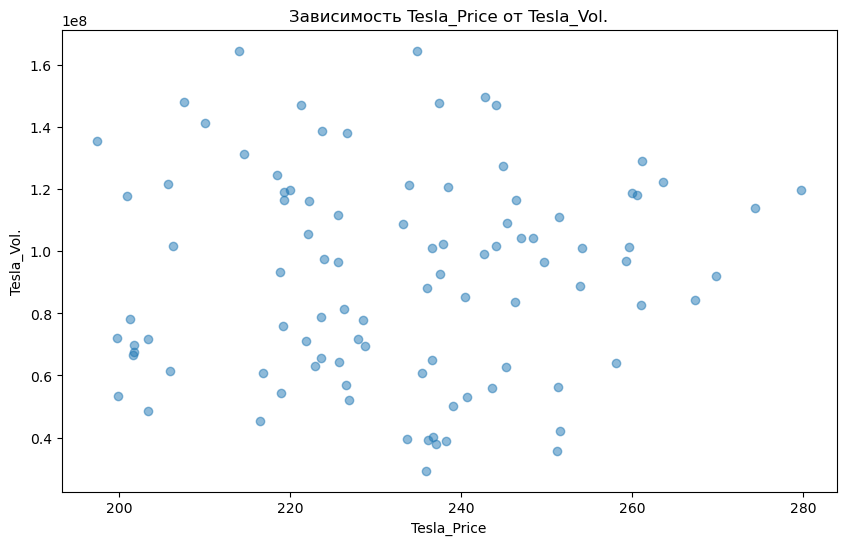

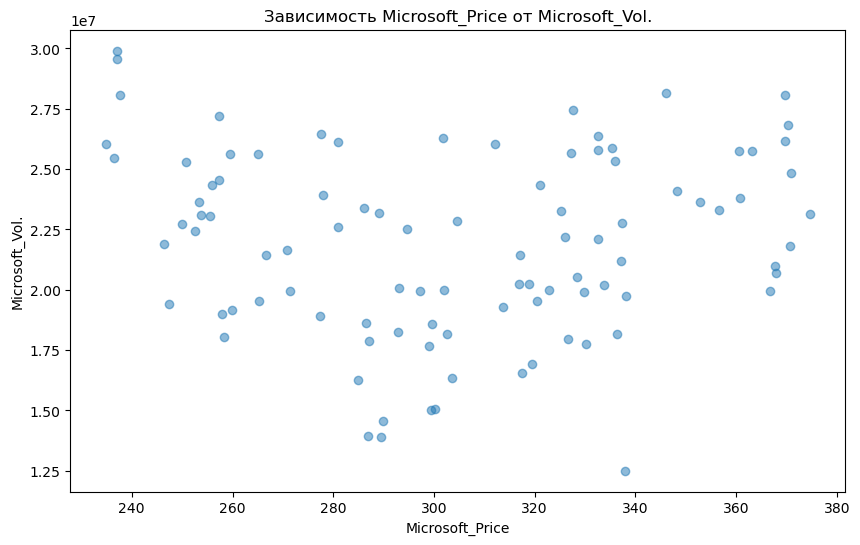

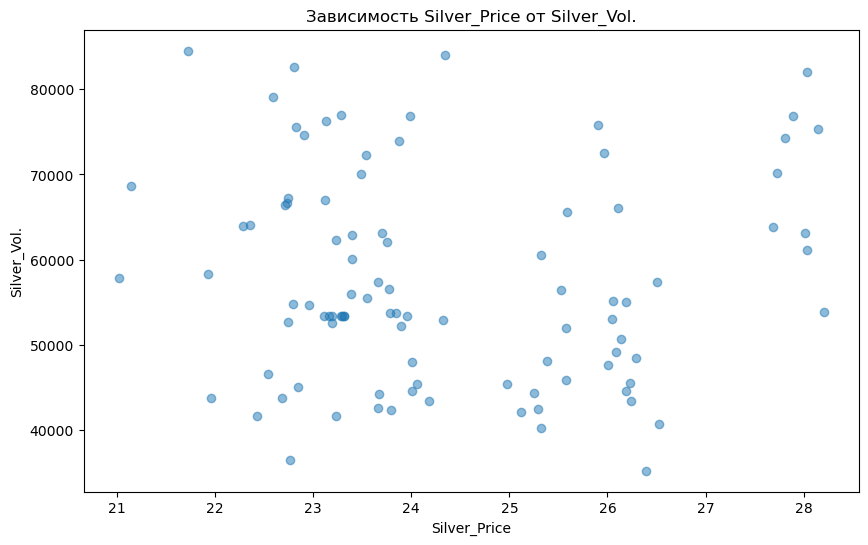

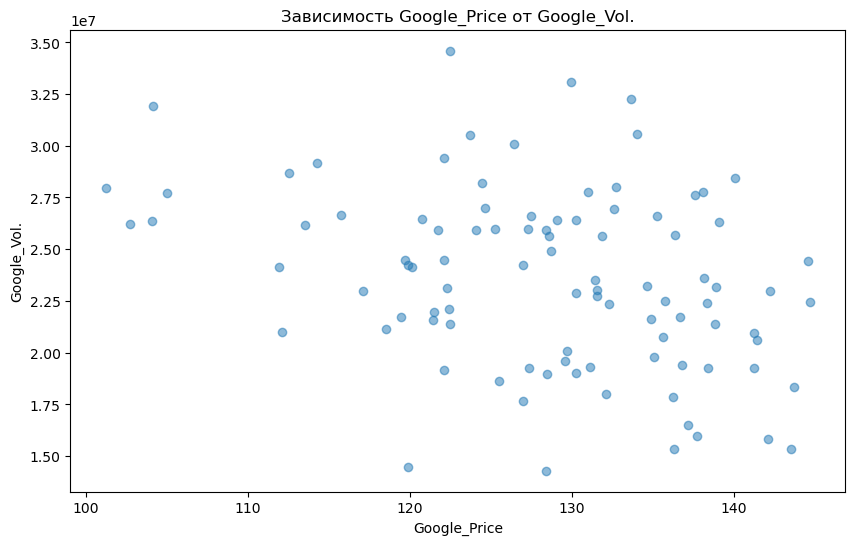

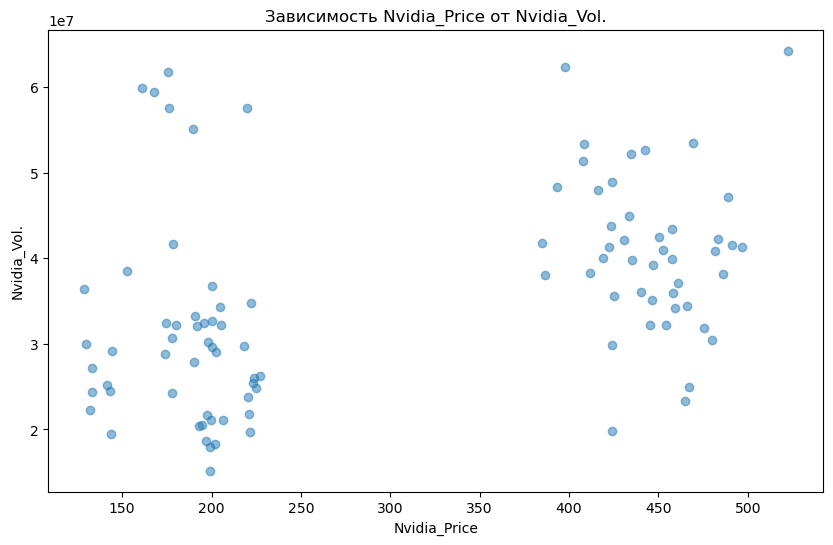

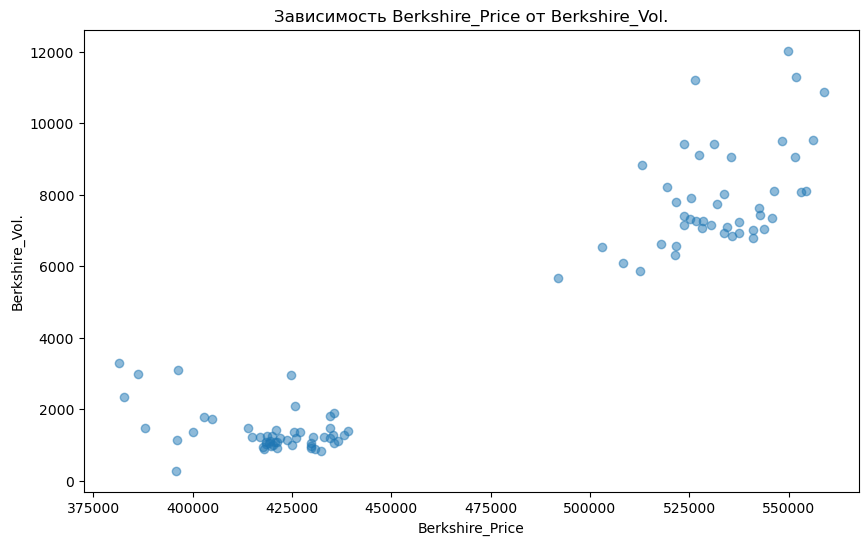

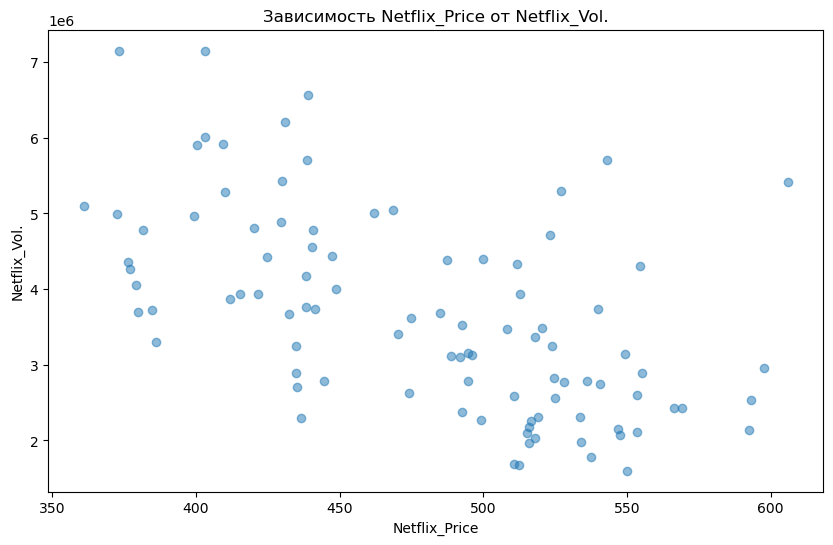

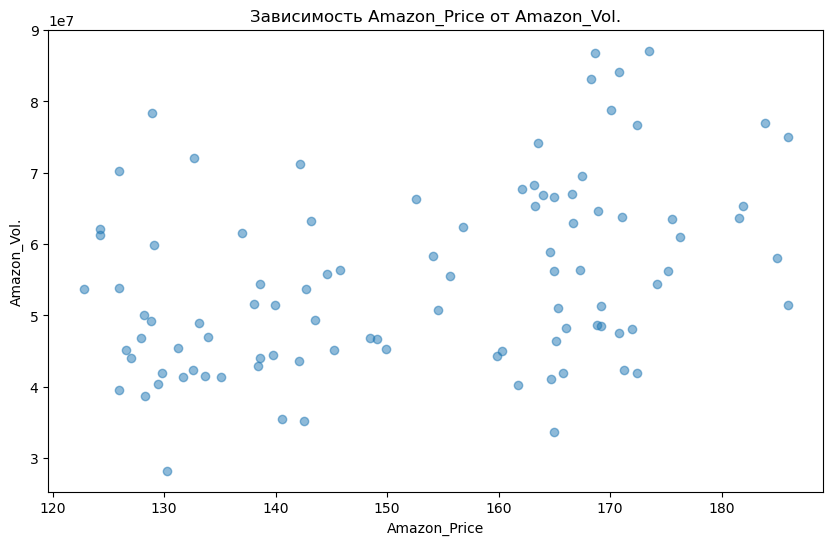

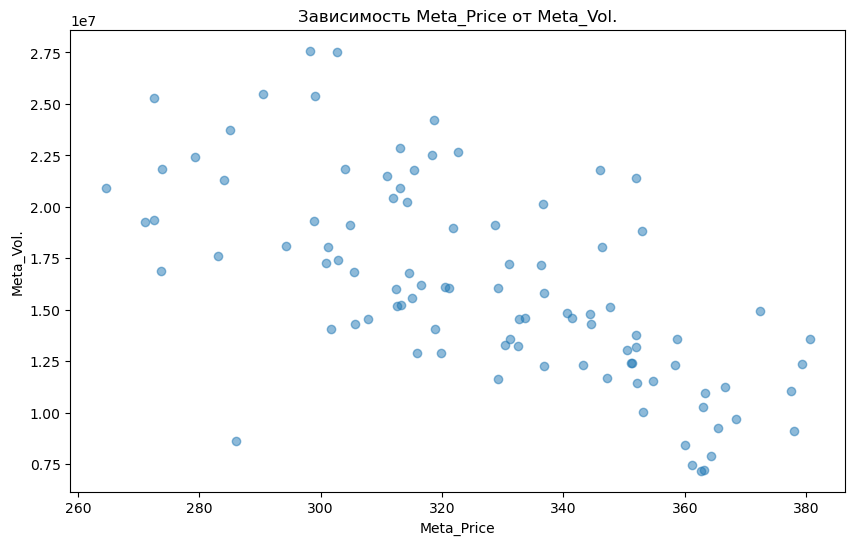

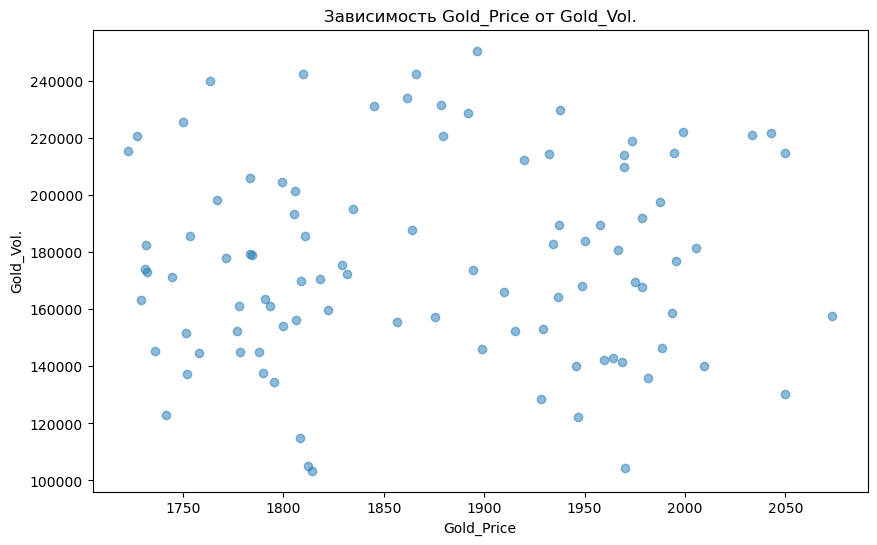

In [7]:
price_columns = [col for col in data.columns if 'Price' in col]
vol_columns = [col for col in data.columns if 'Vol' in col]

columns_pairs = []

for price_col in price_columns:
    base_name = price_col.replace('_Price', '')
    matching_vol = [vol_col for vol_col in vol_columns if base_name in vol_col]
    if matching_vol:
        columns_pairs.append((price_col, matching_vol[0]))

for x_col, y_col in columns_pairs:
    if x_col in data.columns and y_col in data.columns:
        plt.figure(figsize=(10, 6))
        plt.scatter(data[x_col], data[y_col], alpha=0.5)
        plt.title(f'Зависимость {x_col} от {y_col}')
        plt.xlabel(x_col)
        plt.ylabel(y_col)
        plt.show()


применение метода KMeans к моему датасету по заданному примеру. В данном участке происходит обработка компонентво датасета от Apple до Nvidia, так как прошлое описание было акцентированно на них. Далее эти компании обрабатываются по аналогии с второй ссылкой из задания и на выходе для каждой компании получается по два графика. Как видно из этих графиков, то что я описавал выше для них тоже характерно, а именно что у яблочной компании чем дороже акции тем их менее охотно покупают, и что у компании Nvidia после подроста цен акций в следствии бума ИИ их охтно берут из-за высокой перспективы дальнейшего роста

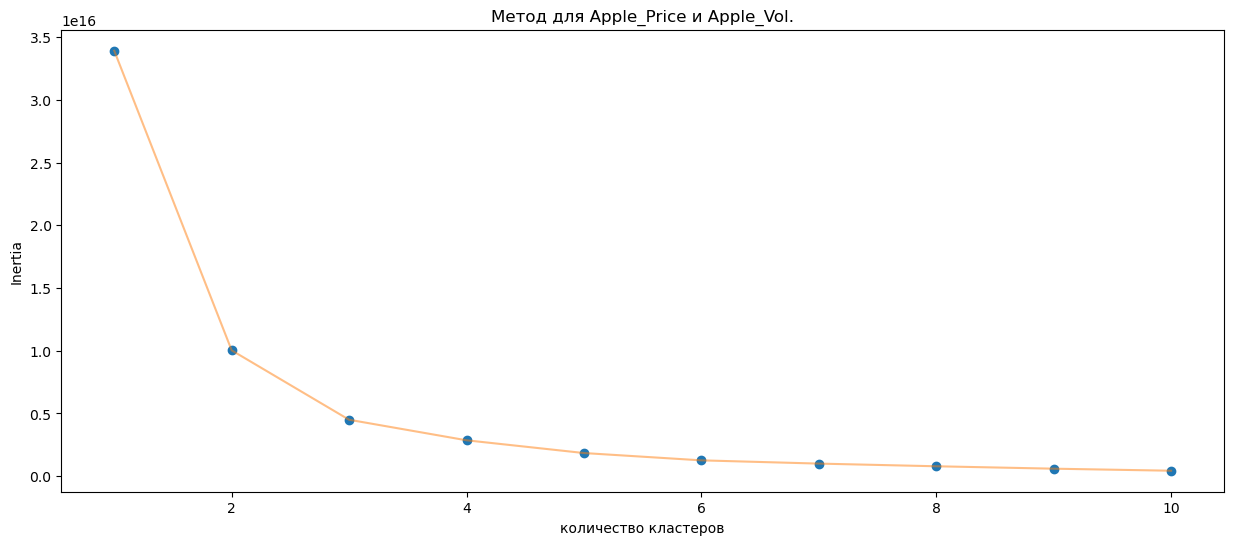

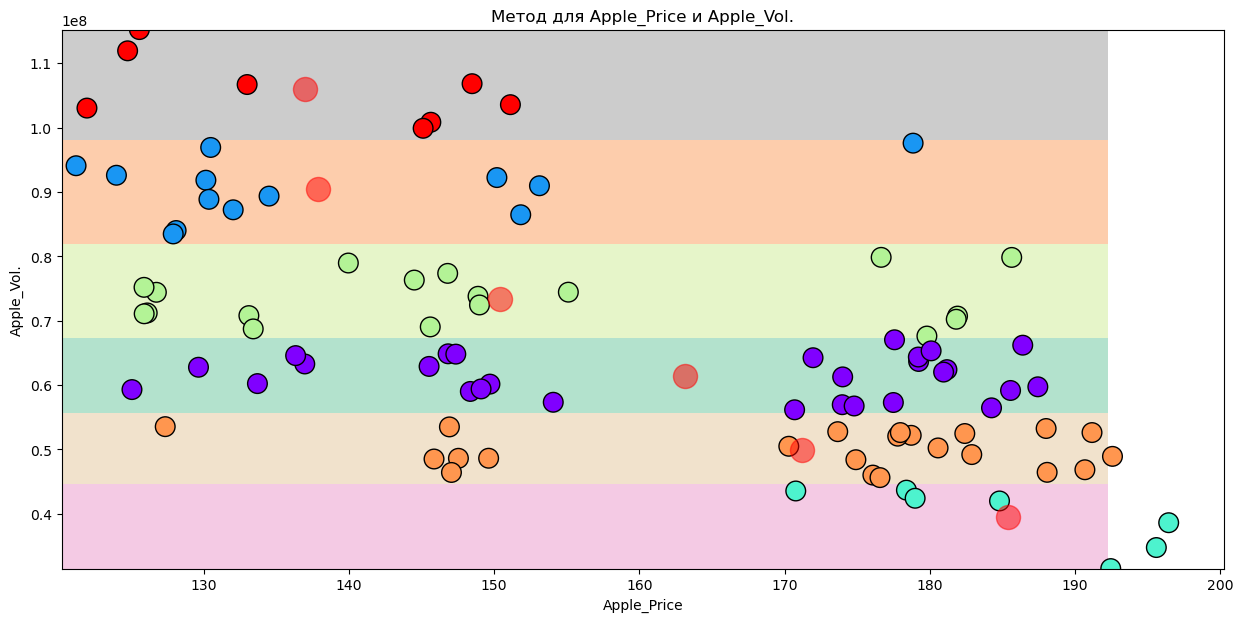

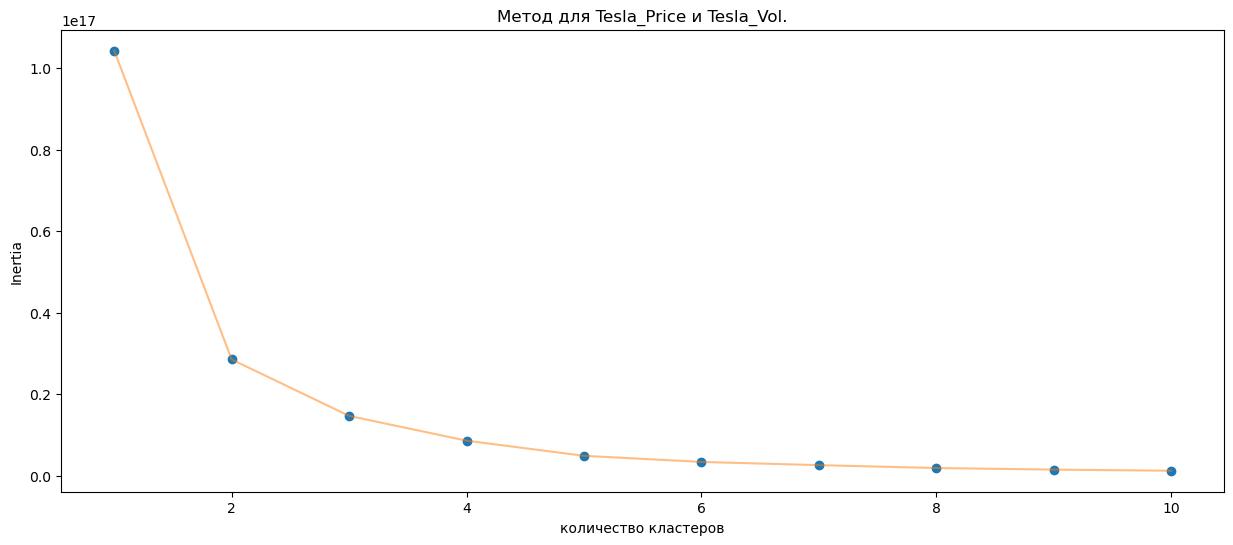

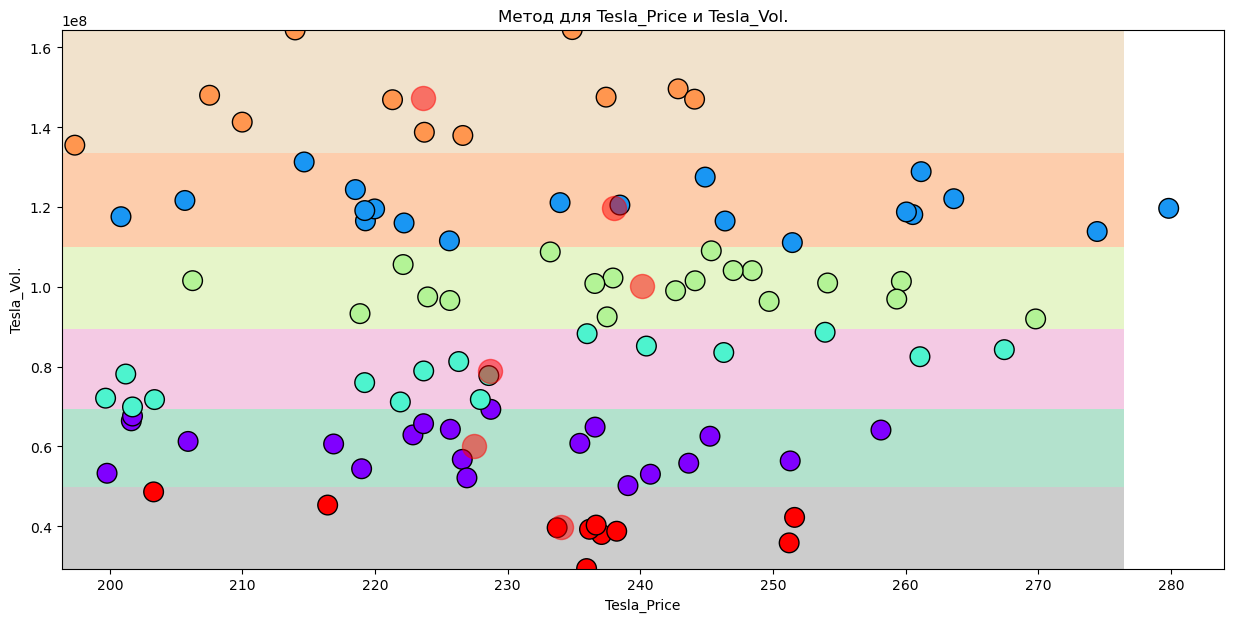

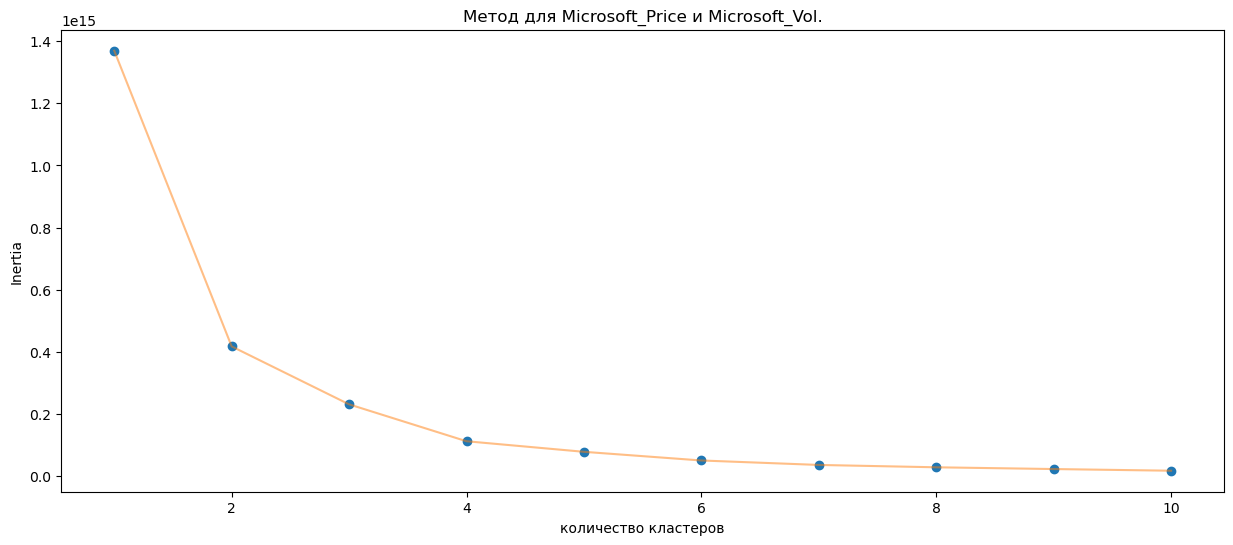

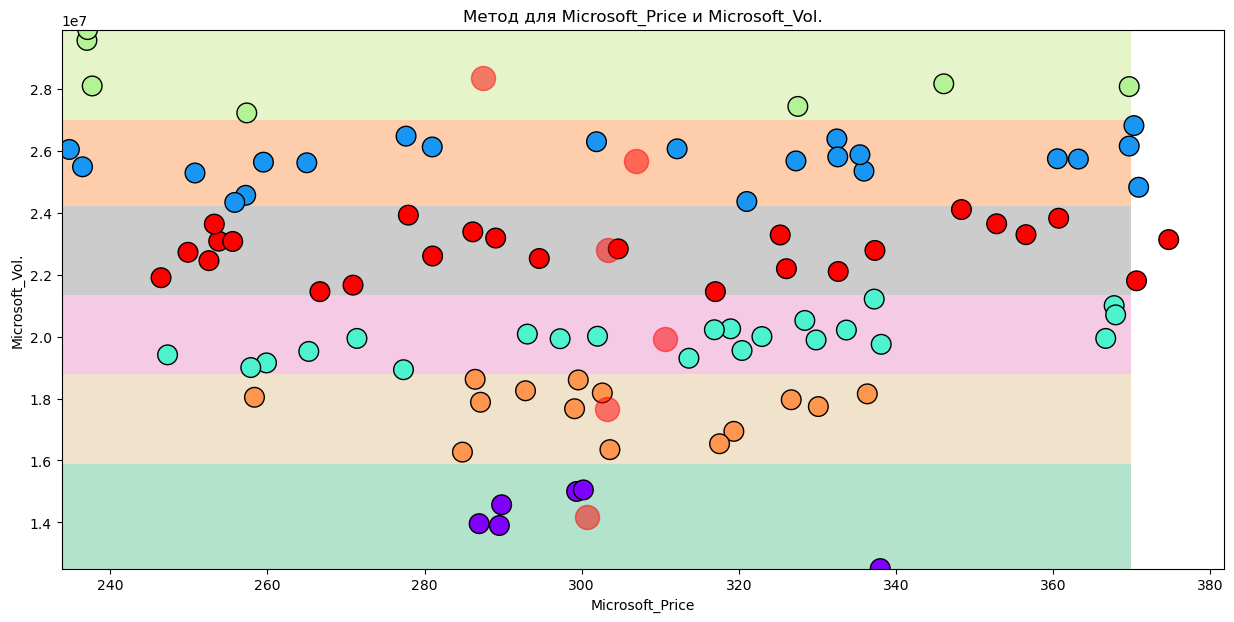

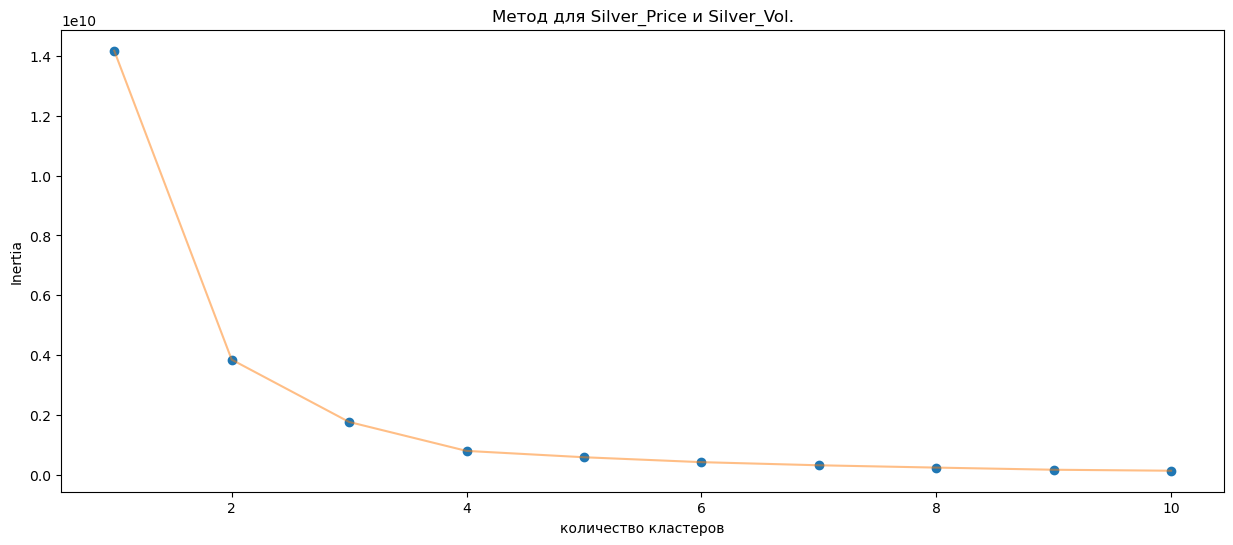

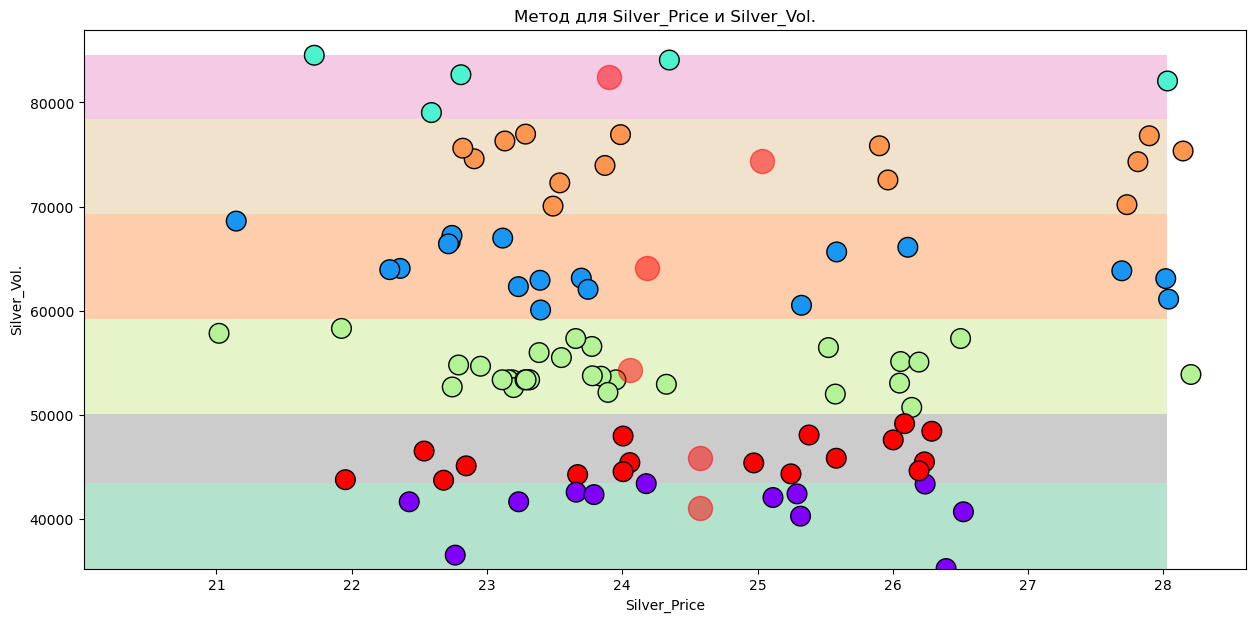

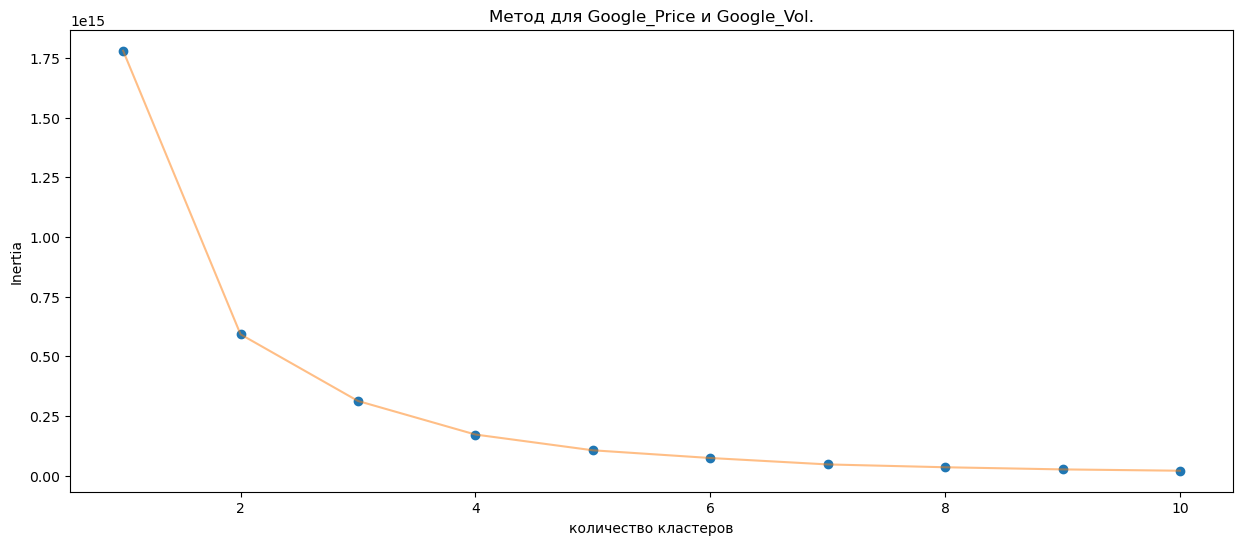

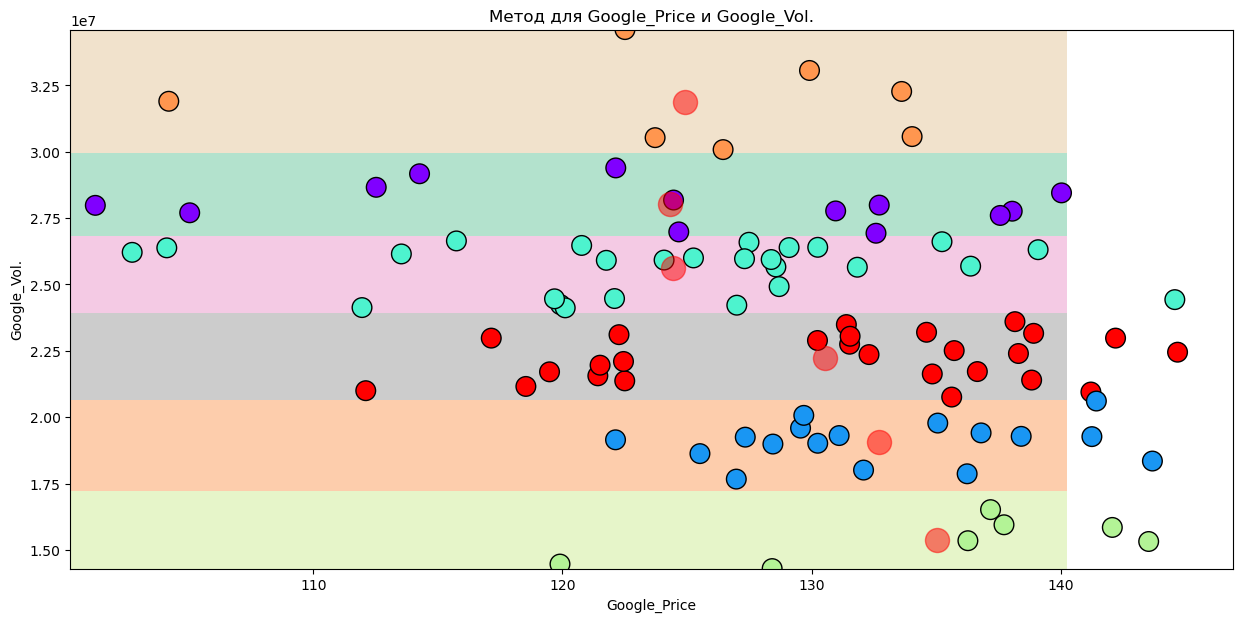

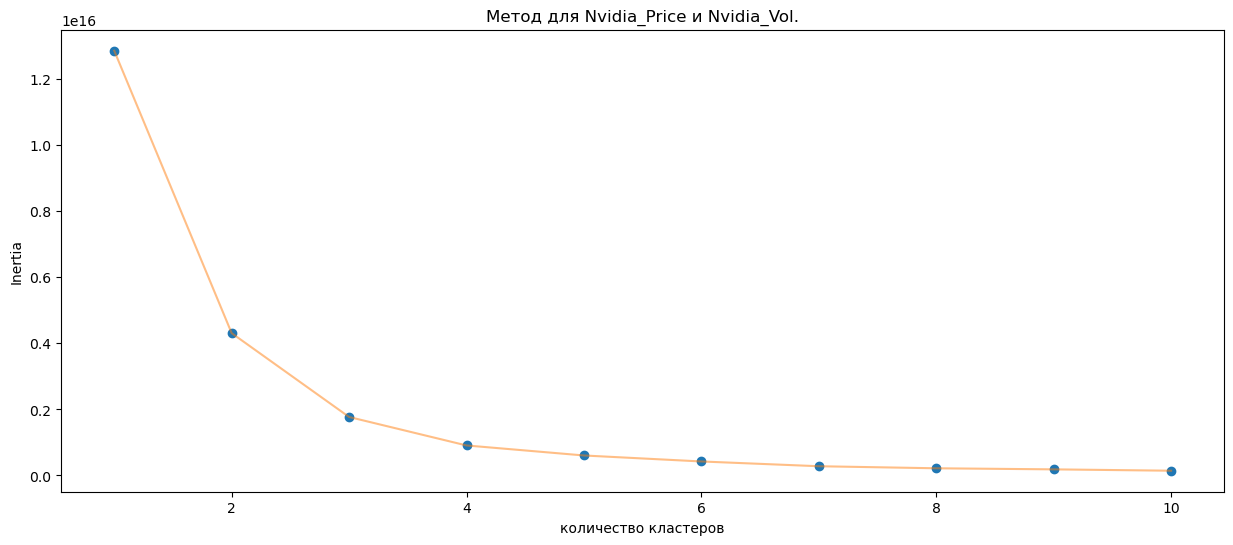

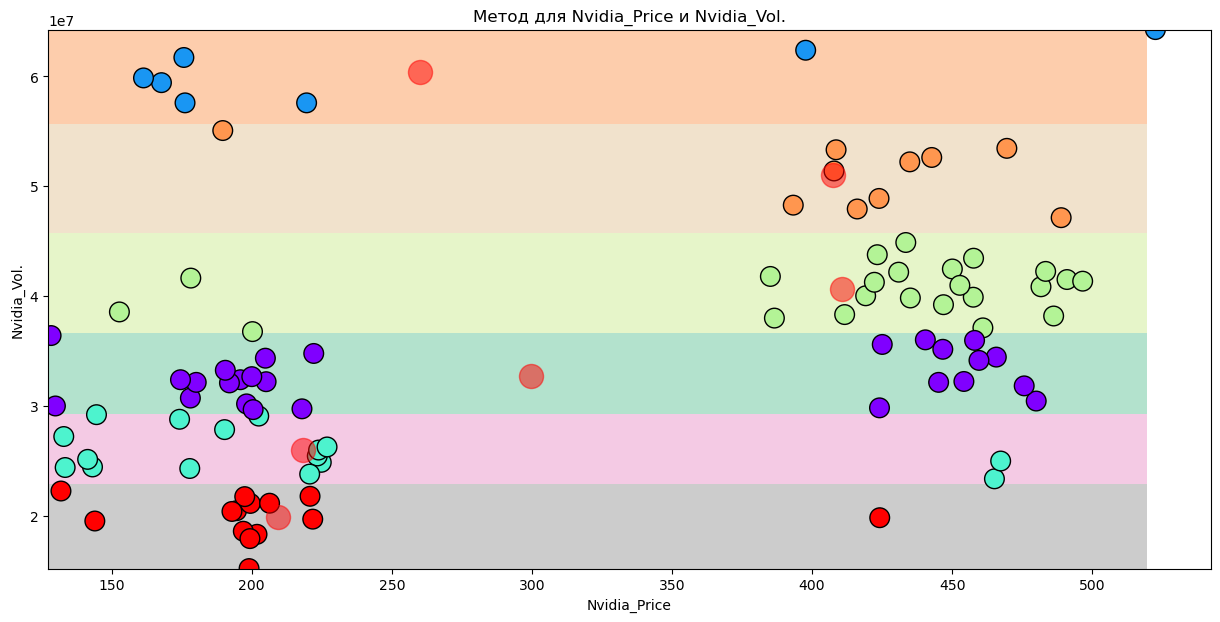

In [12]:
start_index = next(i for i, pair in enumerate(columns_pairs) if 'Apple' in pair[0])

end_index = next(i for i, pair in enumerate(columns_pairs) if 'Nvidia' in pair[0])

selected_pairs = columns_pairs[start_index:end_index+1]



for pr, vol in selected_pairs:
    X1 = data[[pr, vol]].iloc[: , :].values 

    inertia = []
    for n in range(1, 11):
        algorithm = 'lloyd' if n == 1 else 'elkan' 
        kmeans = KMeans(n_clusters=n, init='k-means++', n_init=10, max_iter=300, 
                    tol=0.0001, random_state=111, algorithm=algorithm)
        kmeans.fit(X1)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(15, 6))
    plt.plot(np.arange(1, 11), inertia, 'o')
    plt.plot(np.arange(1, 11), inertia, '-', alpha=0.5)
    plt.xlabel('количество кластеров')
    plt.ylabel('Inertia')
    plt.title(f'Метод для {pr} и {vol}')
    plt.show()

    kmeans = KMeans(n_clusters=6, n_init=10, max_iter=300, random_state=111, algorithm='elkan')
    kmeans.fit(X1)

    labels = kmeans.labels_  
    centroids = kmeans.cluster_centers_  

    h = 8  # Шаг сетки
    x_min, x_max = X1[:, 0].min() - 1, X1[:, 0].max() + 1
    y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])  
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(15, 7))
    plt.imshow(Z, interpolation='nearest', 
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Pastel2, aspect='auto', origin='lower')

    # Нанесение данных и центроидов
    plt.scatter(X1[:, 0], X1[:, 1], c=labels, s=200, edgecolors='k', cmap='rainbow')
    plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='red', alpha=0.5)
    plt.xlabel(pr)
    plt.ylabel(vol)
    plt.title(f'Метод для {pr} и {vol}')
    plt.show()